In [2]:
%load_ext autoreload
%autoreload 2


import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from rlace import solve_adv_game

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from rlace import init_classifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from inlp import get_debiasing_projection
import rlace

unable to import 'smart_open.gcs', disabling that module


## Generate data

In [3]:
random.seed(0)
np.random.seed(0)

USE_GLOVE = True

d=50
n=10000
do_mix = True
CENTER=True
Z_1_prop=0.7
P_y_is_1_given_z_is_1 = 0.6
P_y_is_1_given_z_is_0 = 1 - P_y_is_1_given_z_is_1

std = 1.0
gap = 0.333
mean_y_0 = 1 + gap
mean_y_1 = 1 - gap
mean_z_0 = -1 - gap
mean_z_1 = -1 + gap

mean_y = {0: mean_y_0, 1: mean_y_1}
mean_z = {0: mean_z_0, 1: mean_z_1}


zeros = np.zeros(int((1-Z_1_prop) * n))
ones = np.ones(int(Z_1_prop * n))

z = np.concatenate([zeros, ones], axis=0)
y = []

for zz in z:
    if zz == 1:
        if np.random.rand() < P_y_is_1_given_z_is_1:
            y.append(1)
        else:
            y.append(0)
    elif zz == 0:
        if np.random.rand() < P_y_is_1_given_z_is_0:
            y.append(1)
        else:
            y.append(0)
            
y = np.array(y)
X = []
for zz,yy in zip(z,y):
    v = np.concatenate([np.random.normal(loc=mean_y[yy], scale=std, size=d//2),
                        np.random.normal(loc=mean_z[zz], scale=std, size=d//2)])
    X.append(v)
X = np.array(X)
if do_mix:
    X = X @ np.random.randn(d,d)
    
if CENTER:
    X = X - np.mean(X, axis=0, keepdims=True)
    
X = X / np.linalg.norm(X, axis=1, keepdims=True)

In [4]:
if USE_GLOVE:
    with open("../WWW/rlace/glove/glove-gender-data.pickle", "rb") as f:
        data = pickle.load(f)
        with open("../WWW/rlace/glove/glove-top-50k.pickle", "rb") as f:
            glove_50k = pickle.load(f)
        
    X,z, words = data["train"][0], data["train"][1], data["train"][2]
    
    group1 = ["good", "handsome", "beautiful"]#, "nice", "pleasant", "fun", "enjoy", "happy"]
    group2 = ["bad", "ugly", "brutal"]#, "ugly", "unpleasant", "boring", "suffer", "sad"]

    idx_y1 = [glove_50k["words"].index(w) for w in group1]
    idx_y2 = [glove_50k["words"].index(w) for w in group2]
    vecs_y1 = np.array([glove_50k["vecs"][i] for i in idx_y1])
    vecs_y2 = np.array([glove_50k["vecs"][i] for i in idx_y2])

    v = vecs_y1.mean(axis=0) - vecs_y2.mean(axis=0)
    sims = cosine_similarity([v], X)[0]
    y = (sims > 0).astype(int)
    for i,w in enumerate(words[:20]):
        print(w, "good" if y[i] else "bad", "male" if z[i] else "female")
    print(y.mean())

X = PCA(n_components=d, random_state=0).fit_transform(X)

stoics good male
bookworm good female
bbws bad female
bayless good male
dugout good male
backup good male
naturale good female
infinite good male
longing good female
carcillo bad male
sarbanes bad male
dalia good female
repentance good male
02-03-2012 good female
right-hander good male
luiz good male
diaby good male
zenyatta good female
konata good female
1576 good male
0.6510204081632653


## Statistics

In [5]:
for zz in [0,1]:
    print ("P[y=1|z={}]".format(zz), (y[z==zz]).mean())
    print ("P[y=0|z={}]".format(zz), 1 - (y[z==zz]).mean())
    
print("================")
for yy in [0,1]:
    print ("P[z=1|y={}]".format(yy), (z[y==yy]).mean())
    print ("P[z=0|y={}]".format(yy), 1 - (z[y==yy]).mean())
    
print("===============")
print("P[y=1]={}".format(y.mean()))
print("P[z=1]={}".format(z.mean()))


P[y=1|z=0] 0.7188876651982379
P[y=0|z=0] 0.2811123348017621
P[y=1|z=1] 0.584722969338354
P[y=0|z=1] 0.415277030661646
P[z=1|y=0] 0.6019493177387915
P[z=0|y=0] 0.39805068226120854
P[z=1|y=1] 0.45433646812957157
P[z=0|y=1] 0.5456635318704284
P[y=1]=0.6510204081632653
P[z=1]=0.5058503401360545


In [6]:
combs = []

for yy,zz in zip(y,z):
    combs.append("y={},z={}".format(yy,zz))
    
Counter(combs)

Counter({'y=1,z=1': 2174, 'y=1,z=0': 2611, 'y=0,z=0': 1021, 'y=0,z=1': 1544})

## Classification accuracy

In [507]:
clf_y = init_classifier()
clf_y.fit(X,y)
print("Y prediction accuracy: {}".format(clf_y.score(X,y)))
clf_z = init_classifier()
clf_z.fit(X,z)
print("Z prediction accuracy: {}".format(clf_z.score(X,z)))

clf_z.fit(X[:,d//2:],z)
print("Z prediction accuracy w/o y features: {}".format(clf_z.score(X[:,d//2:],z)))

Y prediction accuracy: 0.8072108843537414
Z prediction accuracy: 1.0
Z prediction accuracy w/o y features: 0.518095238095238


In [349]:
clf_z.coef_.shape

(1, 25)

## PCA

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


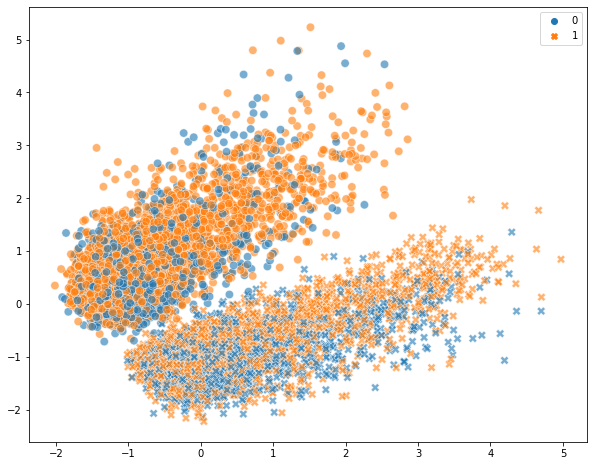

In [508]:
plt.rcParams['figure.figsize'] = [10, 8]
X_pca = PCA(n_components=2).fit_transform(X)
sn.scatterplot(X_pca[:,0], X_pca[:,1], hue = y, style = z, alpha=0.6, s=70)

## Run adversarial game

In [19]:
num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.005, "weight_decay": 1e-5, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.001,"weight_decay": 1e-5, "momentum": 0.9}
epsilon = 0.002 # stop 0.5% from majority acc
batch_size = 32

output = solve_adv_game(X, z, X, z, rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

59000/60000. Acc post-projection: 51.823%; best so-far: 51.034%; Maj: 50.585%; Gap: 0.449%; best loss so far: -1.000: 100%|##########| 60000/60000 [06:25<00:00, 155.61it/s]


In [20]:
clf = SGDClassifier(max_iter=250000, n_iter_no_change=150)
clf.fit(X@output["P"], z)
clf.score(X@output["P"], z)

0.5293877551020408

In [8]:
def get_entropy(y):
    
    counts = Counter(y)
    fracts = [c/sum(counts.values()) for c in counts.values()]
    return scipy.stats.entropy(fracts)

get_entropy(z)

0.6930787260385087

In [74]:
def train_single_hidden_neuron_net(X, z, nonlinearity = True, hidden_neurons = 2, sigmoid=False):

    # create an MLP with a single sigmoid neuron
    
    if nonlinearity:
        if sigmoid:
            net = torch.nn.Sequential(torch.nn.Linear(X.shape[1], 1,bias=False), torch.nn.Sigmoid(),
                             torch.nn.Linear(1, 1, bias=True))
        else:
            net = torch.nn.Sequential(torch.nn.Linear(X.shape[1], hidden_neurons), torch.nn.Softmax(dim=1),
                             torch.nn.Linear(hidden_neurons, 1))
    else:
        net = torch.nn.Sequential(torch.nn.Linear(X.shape[1], 1))
        
    X_torch = torch.tensor(X).float()
    z_torch = torch.tensor(z).float()

    optimizer = torch.optim.Adam(net.parameters())
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for t in range(25000):
        optimizer.zero_grad()

        y_pred = net(X_torch)
        loss = loss_fn(y_pred.squeeze(), z_torch)
        loss.backward()
        optimizer.step()
        
        if t % 1000 == 0:
            print(loss.detach().cpu().numpy().item())
        
    return net

def get_loss_value(net, X, z):
    X_torch = torch.tensor(X).float()
    z_torch = torch.tensor(z).int()
    y_pred = net(X_torch)
    loss = torch.nn.BCEWithLogitsLoss()(y_pred, z_torch)
    return loss.item().detach().cpu().numpy()

def get_classification_accuracy(net, X, z):
    # calculate the accuracy of the sigmoid network

    X_torch = torch.tensor(X).float()
    z_torch = torch.tensor(z).int()
    y_pred = (net(X_torch) > 0).int()
    acc = (y_pred.detach().cpu().squeeze().int().numpy() == z).astype(int).mean()
    return acc

net = train_single_hidden_neuron_net(X@output["P"],z, nonlinearity=True, hidden_neurons=16, sigmoid=False)
acc = get_classification_accuracy(net, X@output["P"], z)
print("Accuracy", acc)

0.6993609070777893
0.3195858597755432
0.17288927733898163
0.10804885625839233
0.06915217638015747
0.04636620730161667
0.03262517973780632
0.023791544139385223
0.018994756042957306
0.016266904771327972
0.014733944088220596
0.013859857805073261
0.013311171904206276
0.012784050777554512
0.012467997148633003
0.012240284122526646
0.012008864432573318
0.01114580500870943
0.011029857210814953
0.010949620977044106
0.010866311378777027
0.01077206525951624
0.010663717053830624
0.009976438246667385
0.009856841526925564
Accuracy 0.9985034013605442


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.8361904761904762

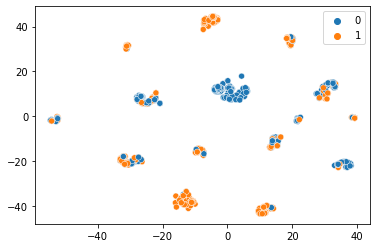

In [84]:
reps = net[:2](torch.tensor(X)).detach().cpu().numpy()
reps_pca = TSNE(n_components=2).fit_transform(reps[:1000])
sn.scatterplot(reps_pca[:,0], reps_pca[:,1], hue=z[:len(reps_pca)])

clf = init_classifier()
clf.fit(reps, z[:len(reps)])
clf.score(reps, z[:len(reps)])

In [87]:
argmax_idx = np.argmax(reps, axis=1)
reps_copy = reps.copy()
for i,r in enumerate(reps_copy):
    for j in range(len(r)):
        if j == argmax_idx[i]:
            reps_copy[i][j] = 1.0
        else:
            reps_copy[i][j] = 0.0
            
clf = init_classifier()
clf.fit(reps_copy, z[:len(reps_copy)])
clf.score(reps_copy, z[:len(reps_copy)])

0.8287074829931973

In [88]:
reps_copy.shape

(7350, 16)

In [73]:
def build_equivalent_linear_model(net,X):
    
    if net[0].weight.shape[0] == 2:
        alpha = (net[0].weight[0]-net[0].weight[1]).detach().clone().detach().cpu().numpy()
        print(net[2].weight)
        beta = (net[2].weight[0][0]-net[0].weight[0][1]).detach().clone().detach().cpu().numpy()
    else:
        alpha = net[0].weight.detach().clone().detach().cpu().numpy()
        beta = net[2].weight.detach().clone().detach().cpu().numpy()
        
    threshold = 0.5
    
    gamma = net[2].bias.detach().clone().detach().cpu().numpy()
    
    model = torch.nn.Linear(X.shape[1], 1)
    model.weight.data = torch.tensor(alpha).float()
    D = -(np.log((1-threshold)/threshold) + gamma)/beta
    new_threshold = torch.tensor(-np.log((1-D)/D)).float()
    model.bias.data = -new_threshold 
    return model

model = build_equivalent_linear_model(net, X)
acc = get_classification_accuracy(net, X@output["P"], z)
acc

0.6314285714285715

In [18]:
model.bias

Parameter containing:
tensor([[0.2046]], requires_grad=True)

In [11]:
def get_preds(xs,ys):
    return np.array([ys.mean() for x in xs])

preds = get_preds(X, z)
sklearn.metrics.log_loss(z, preds)

0.693078726038509

In [475]:
def get_tpr(y_hat, y, z):
    
    tpr_y_1_z_1 = (y_hat[(z==1) & (y==1)] == 1).mean()
    tpr_y_1_z_0 = (y_hat[(z==0) & (y==1)] == 1).mean()
    
    tpr_y_0_z_1 = (y_hat[(z==1) & (y==0)] == 0).mean()
    tpr_y_0_z_0 = (y_hat[(z==0) & (y==0)] == 0).mean()
    
    return {"P[y_hat=1|y=1 & z=1]": tpr_y_1_z_1, "P[y_hat=1|y=1 & z=0]": tpr_y_1_z_0,
           "P[y_hat=0|y=0 & z=1]": tpr_y_0_z_1, "P[y_hat=0|y=0 & z=0]": tpr_y_0_z_0}

def stringify(preds_dict, z):
    out = []
    
    for k in sorted(preds_dict.keys()):
        out.append("P[y_hat={}|z={}]={}".format(k,z,preds_dict[k]) if z is not None else "P[y_hat={}]={}".format(k,preds_dict[k]))
    
    return "; ".join(out)
        
def get_y_hat(trained_clf, X, z):

    preds = trained_clf.predict(X)
    preds_z_0 = trained_clf.predict(X[z==0])
    preds_z_1 = trained_clf.predict(X[z==1])
    couner_preds, counter_preds_z_0, counter_preds_z_1 = Counter(preds), Counter(preds_z_0),  Counter(preds_z_1)
    
    probs_all = {k:v/sum(couner_preds.values()) for k,v in couner_preds.items()}
    probs_z_0 = {k:v/sum(counter_preds_z_0.values()) for k,v in counter_preds_z_0.items()}
    preds_z_1 = {k:v/sum(counter_preds_z_1.values()) for k,v in counter_preds_z_1.items()}

    return {"preds_all": stringify(probs_all, None), "preds_z_0": stringify(probs_z_0, 0), "preds_z_1": stringify(preds_z_1,1),
    }, preds

    
class MyGenderClassifier(object):
    
    def __init__(self, trained_main_task_clf, X, z):
        self.clf = trained_main_task_clf
        
        # collect predictions, find argmax_y | P[Y_hat = y|z=0] - P[Y_hat = y|z=1] | 
        
        preds = get_y_hat(trained_main_task_clf, X, z)
        diffs = {}
        
        for yval in set(preds["preds_all"]):
            diffs[yval] = np.abs(preds["preds_z_0"][yval] - preds["preds_z_1"][yval])
            
        argmax_y = sorted([(yval, diff) for (yval, diff) in diffs.items()], key = lambda pair: pair[1])[-1][0]
        self.argmax_y = argmax_y
        
        # compare P[Y=argmax_y|Z=1], P[Y=argmax_y|Z=0]
        
        self.P_y_is_argmax_y_given_z_is_1 = preds["preds_z_1"][argmax_y]
        self.P_y_is_argmax_y_given_z_is_0 = preds["preds_z_0"][argmax_y]
        self.return_1_on_argmax_y = True if self.P_y_is_argmax_y_given_z_is_1 > self.P_y_is_argmax_y_given_z_is_0 else False
        
    def predict(self, x):
        
        y_hat = self.clf.predict([x])[0]
        
        if self.P_y_is_argmax_y_given_z_is_1 > self.P_y_is_argmax_y_given_z_is_0:
            
            if y_hat == self.argmax_y:               
                return 1
            else:
                return 0           
        else:           
            if y_hat == self.argmax_y:
                return 0
            else:
                return 1

## Collect the distriution of prediction $\hat{Y}$ before and after projection

In [460]:
clf_before = init_classifier()
clf_before.fit(X,y)
preds_before = get_y_hat(clf_before, X, z)
print(clf_before.score(X,y))

0.9471


### P[$\hat{Y}|X$]

In [461]:
preds_before

({'preds_all': 'P[y_hat=0]=0.4558; P[y_hat=1]=0.5442',
  'preds_z_0': 'P[y_hat=0|z=0]=0.605; P[y_hat=1|z=0]=0.395',
  'preds_z_1': 'P[y_hat=0|z=1]=0.39185714285714285; P[y_hat=1|z=1]=0.6081428571428571'},
 array([0, 0, 0, ..., 0, 1, 0]))

In [492]:
clf_before.predict_proba(X)

array([[0.98677738, 0.01322262],
       [0.84394223, 0.15605777],
       [0.98142391, 0.01857609],
       ...,
       [0.97052425, 0.02947575],
       [0.0207126 , 0.9792874 ],
       [0.99215413, 0.00784587]])

In [462]:
clf_z_based_on_y = init_classifier()
clf_z_based_on_y.fit(clf_before.predict(X)[:,None], z)
clf_z_based_on_y.score(clf_before.predict(X)[:,None], z)

0.7

In [463]:
clf_z_based_on_y.coef_, clf_z_based_on_y.intercept_

(array([[0.80229601]]), array([0.36011099]))

In [464]:
clf_z_based_on_y = init_classifier()
clf_z_based_on_y.fit(clf_before.predict_proba(X), z)
clf_z_based_on_y.score(clf_before.predict_proba(X), z)


0.7

In [465]:
clf_z_based_on_y.coef_, clf_z_based_on_y.intercept_

(array([[-0.54066749,  0.55795796]]), array([0.90957503]))

In [466]:
get_cross_entropy(z, clf_z_based_on_y.predict_proba(clf_before.predict_proba(X)))

0.589841677165169

In [467]:
get_entropy(z)

0.6108643020548935

### P[$\hat{Y}|XP$]

In [468]:
clf_after = init_classifier()
clf_after.fit(X@output["P"],y)
preds_after = get_y_hat(clf_after, X@output["P"], z)
print(clf_after.score(X@output["P"], y))
print(get_cross_entropy(y, clf_after.predict_proba(X@output["P"])))

0.9279
0.1865064568844611


In [469]:
preds_after

({'preds_all': 'P[y_hat=0]=0.4562; P[y_hat=1]=0.5438',
  'preds_z_0': 'P[y_hat=0|z=0]=0.5286666666666666; P[y_hat=1|z=0]=0.4713333333333333',
  'preds_z_1': 'P[y_hat=0|z=1]=0.42514285714285716; P[y_hat=1|z=1]=0.5748571428571428'},
 array([0, 1, 0, ..., 0, 1, 0]))

In [470]:
clf_z_after = init_classifier()
clf_z_after.fit(X@output["P"],z)
print(clf_z_after.score(X@output["P"], z))
print(get_cross_entropy(z, clf_z_after.predict_proba(X@output["P"])))

0.7
0.6070744462076804


In [471]:
probs = clf_after.predict_proba(X@output["P"])
probs_y_0 = probs[:,0]
probs_y_1 = probs[:,1]
probs_y_0_given_z_is_0 = probs_y_0[z==0]
probs_y_0_given_z_is_1 = probs_y_0[z==1]
probs_y_1_given_z_is_0 = probs_y_1[z==0]
probs_y_1_given_z_is_1 = probs_y_1[z==1]

loss_clf_after = get_cross_entropy(z, clf_z.predict_proba(X@output["P"])) #sklearn.metrics.log_loss(z, clf_z.predict_proba(X@output["P"]))
loss_clf_after_on_z_0 = get_cross_entropy(y[z==0], clf_after.predict_proba( (X@output["P"])[z==0] ))
loss_clf_after_on_z_1 = get_cross_entropy(y[z==1], clf_after.predict_proba( (X@output["P"])[z==1] ))

print(probs_y_0_given_z_is_0.mean(), probs_y_0_given_z_is_1.mean())
print(probs_y_1_given_z_is_0.mean(), probs_y_1_given_z_is_1.mean())
print(loss_clf_after, loss_clf_after_on_z_0, loss_clf_after_on_z_1)

0.5035190643350901 0.4406667890883503
0.49648093566491 0.5593332109116497
0.9308792684798333 0.2158636412847128 0.17392480642721123


## MI before

In [489]:
mi_before = sklearn.metrics.mutual_info_score(z, clf_before.predict(X))

In [501]:
mi_before

0.01925504480996551

## MI after

In [490]:
mi_after = sklearn.metrics.mutual_info_score(z, clf_after.predict(X@output["P"]))

In [491]:
mi_before/mi_after

4.254190291603911

In [500]:
from sklearn import feature_selection
sklearn.feature_selection.mutual_info_classif(clf_before.predict_proba(X), z)

array([0.02269846, 0.02269846])

In [272]:
def get_cross_entropy(true, pred):
    
    loss = 0.0
    for p,t in zip(pred,true):
        loss += -np.log(p[int(t)])
    return loss / len(pred)

In [273]:
get_cross_entropy(z, clf_z.predict_proba(X@output["P"]))

0.6990763644556953

In [274]:
clf_z = SGDClassifier(loss="log", max_iter=250000, n_iter_no_change=250)
clf_z.fit(X@output["P"], z)
loss = get_cross_entropy(z, clf_z.predict_proba(X@output["P"])) #sklearn.metrics.log_loss(z, clf_z.predict_proba(X@output["P"]))
loss_on_z_0 = get_cross_entropy(z[z==0], clf_z.predict_proba( (X@output["P"])[z==0] ))
loss_on_z_1 = get_cross_entropy(z[z==1], clf_z.predict_proba( (X@output["P"])[z==1] ))

print(loss, loss_on_z_0, loss_on_z_1, get_entropy(z))
print(get_cross_entropy(z, clf_z.predict_proba(X@output["P"])))

0.5808896459991407 1.1492601813078758 0.33730227372396593 0.6108643020548935
0.5808896459991407


### PCA after

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


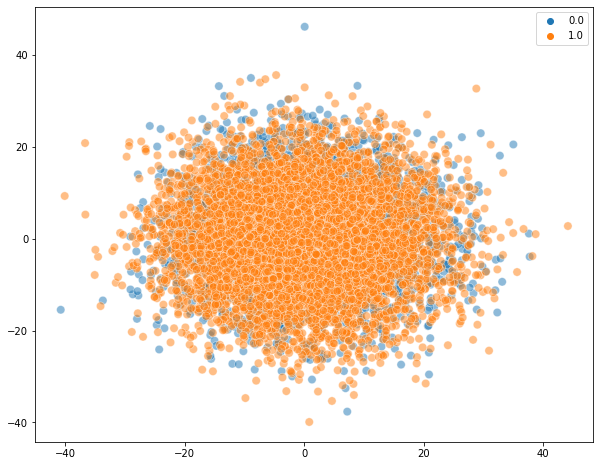

In [63]:
plt.rcParams['figure.figsize'] = [10, 8]
X_pca_after = PCA(n_components=2).fit_transform(X@output["P"])
sn.scatterplot(X_pca_after[:,0], X_pca_after[:,1], hue = z, alpha=0.5, s=70)

## per class adversarial

In [420]:
num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.01, "weight_decay": 1e-4, "momentum":0.0}
optimizer_params_predictor = {"lr": 0.01,"weight_decay": 1e-5, "momentum": 0.9}
epsilon = 0.005 # stop 0.5% from majority acc
batch_size = 32

output_y_0 = solve_adv_game(X[y==0], z[y==0], X[y==0], z[y==0], rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

1000/60000. Acc post-projection: 61.326%; best so-far: 61.326%; Maj: 60.195%; Gap: 1.131%; best loss so far: 0.669:   2%|1         | 1000/60000 [00:28<27:45, 35.42it/s]


In [438]:
get_entropy(z[y==0]), get_entropy(z[y==1])

(0.6722133660380342, 0.6889710476671475)

In [422]:
output_y_1 = solve_adv_game(X[y==1], z[y==1], X[y==1], z[y==1], rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

1000/60000. Acc post-projection: 58.077%; best so-far: 58.077%; Maj: 54.566%; Gap: 3.511%; best loss so far: 0.686:   2%|1         | 1000/60000 [00:29<29:03, 33.84it/s]


In [430]:
P_y_0 = output_y_0["P"]
P_y_1 = output_y_1["P"]

X_projected = X.copy()
X_projected[y==1] =  (X_projected[y==1]) @ P_y_0
X_projected[y==0] =  (X_projected[y==0]) @ P_y_1

In [445]:
clf_after = init_classifier()
clf_after.fit(X_projected,y)
preds_after = get_y_hat(clf_after, X_projected, z)
print(clf_after.score(X_projected, y))

0.805578231292517


In [432]:
preds_after

({'preds_all': 'P[y_hat=0]=0.28965986394557824; P[y_hat=1]=0.7103401360544218',
  'preds_z_0': 'P[y_hat=0|z=0]=0.2767070484581498; P[y_hat=1|z=0]=0.7232929515418502',
  'preds_z_1': 'P[y_hat=0|z=1]=0.3023130715438408; P[y_hat=1|z=1]=0.6976869284561592'},
 array([1, 1, 0, ..., 0, 0, 1]))

In [452]:
preds = clf_before.predict(X_projected)
sklearn.metrics.mutual_info_score(z, preds)

0.0016533914437725783

In [433]:
clf_z = init_classifier()
clf_z.fit(X_projected, z)
clf_z.score(X_projected, z)

0.7847619047619048

In [434]:
loss_clf_after = get_cross_entropy(y, clf_after.predict_proba(X_projected)) #sklearn.metrics.log_loss(z, clf_z.predict_proba(X@output["P"]))
loss_clf_after_on_z_0 = get_cross_entropy(y[z==0], clf_after.predict_proba( (X_projected)[z==0] ))
loss_clf_after_on_z_1 = get_cross_entropy(y[z==1], clf_after.predict_proba( (X_projected)[z==1] ))
print(loss_clf_after, loss_clf_after_on_z_0, loss_clf_after_on_z_1)

0.4151112350899371 0.36398621880699916 0.46505369316944817


In [435]:
preds = clf_after.predict(X_projected)
print("tpr y=1", preds[(y==1)].mean(), preds[(y==1) & (z==0)].mean(), preds[(y==1) & (z==1)].mean())
print("tpr y=0", (1-preds[(y==0)]).mean(), (1-preds[(y==0) & (z==0)]).mean(), (1-preds[(y==0) & (z==1)]).mean())
print("fpr y=1", preds[(y==0)].mean(), preds[(y==0) & (z==0)].mean(), preds[(y==0) & (z==1)].mean())
print("fpr y=0", (1-preds[(y==1)]).mean(), (1-preds[(y==1) & (z==0)]).mean(), (1-preds[(y==1) & (z==1)]).mean())

tpr y=1 0.8940438871473354 0.8889314438912295 0.9001839926402944
tpr y=0 0.6323586744639377 0.7002938295788442 0.5874352331606217
fpr y=1 0.3676413255360624 0.2997061704211557 0.41256476683937826
fpr y=0 0.10595611285266458 0.11106855610877059 0.09981600735970561


### tpr before

In [442]:
preds = clf_before.predict(X)
print("tpr y=1", preds[(y==1)].mean(), preds[(y==1) & (z==0)].mean(), preds[(y==1) & (z==1)].mean())
print("tpr y=0", (1-preds[(y==0)]).mean(), (1-preds[(y==0) & (z==0)]).mean(), (1-preds[(y==0) & (z==1)]).mean())
print("fpr y=1", preds[(y==0)].mean(), preds[(y==0) & (z==0)].mean(), preds[(y==0) & (z==1)].mean())
print("fpr y=0", (1-preds[(y==1)]).mean(), (1-preds[(y==1) & (z==0)]).mean(), (1-preds[(y==1) & (z==1)]).mean())

tpr y=1 0.8716823406478579 0.9084641899655305 0.827506899724011
tpr y=0 0.6978557504873294 0.6493633692458374 0.7299222797927462
fpr y=1 0.30214424951267055 0.35063663075416257 0.2700777202072539
fpr y=0 0.12831765935214212 0.09153581003446955 0.17249310027598896


In [444]:
acc_on_z_0 = (preds[z==0] == y[z==0]).mean()
acc_on_z_z = (preds[z==z] == y[z==z]).mean()
print(acc_on_z_0, acc_on_z_z)

0.8356277533039648 0.8110204081632653


In [135]:
probs = clf_after.predict_proba(X_projected)
probs[:,0][(y==0) & (z==0)].mean(), probs[:,0][(y==0) & (z==1)].mean()

(0.8238635210236442, 0.8619024779974359)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


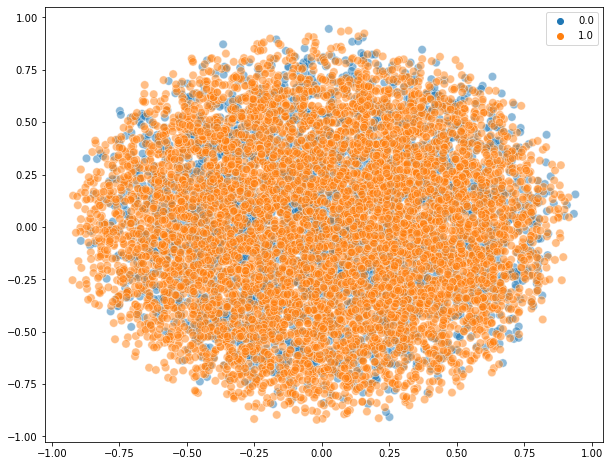

In [339]:
plt.rcParams['figure.figsize'] = [10, 8]
X_pca_after = PCA(n_components=2).fit_transform(X_projected)
sn.scatterplot(X_pca_after[:,0], X_pca_after[:,1], hue = z, alpha=0.5, s=70)

### Construct the reduction classifier and calculate its gender prediction accuracy

In [ ]:
reduction_clf = MyGenderClassifier(clf_after, X@output["P"],z)

In [ ]:
preds_reduction = np.array([reduction_clf.predict(x) for x in X@output["P"]])
reduction_acc = (preds_reduction==z).mean()
print(reduction_acc)

### Calcualte accuracy of sklearn classifiers on the projected data $XP$

In [ ]:
clf = init_classifier()
clf.fit(X@output["P"],z)
print(clf.score(X@output["P"],z))

clf = SGDClassifier(loss="huber")
clf.fit(X@output["P"],z)
print(clf.score(X@output["P"],z))

In [ ]:
clf.coef_

In [ ]:
clf_after.coef_

In [ ]:
clf = init_classifier()
clf.fit(X[y==0]@output["P"],z[y==0])
clf.score(X[y==0]@output["P"],z[y==0])

In [ ]:
clf = init_classifier()
clf.fit(X[y==1]@output["P"],z[y==1])
clf.score(X[y==1]@output["P"],z[y==1])

## torch classifier

In [ ]:
predictor = torch.nn.Linear(d, 1)
predictor.weight.data = torch.tensor(clf_after.coef_).float()
predictor.bias.data = torch.tensor(clf_after.intercept_).float()


bce_loss_fn = torch.nn.BCEWithLogitsLoss()
X_torch = torch.tensor(X@output["P"]).float()
z_torch = torch.tensor(z).float()
optimizer = torch.optim.SGD(predictor.parameters(), lr=1e-5, momentum=0.9)
batch_size = X.shape[0]
best_predictor = None
best_loss = 100.0

for i in range(300):
    optimizer.zero_grad()
    idx = np.arange(0, X_torch.shape[0])
    np.random.shuffle(idx)
    X_batch, y_batch = X_torch[idx[:batch_size]], z_torch[idx[:batch_size]]
    bce = bce_loss_fn(predictor(X_batch).squeeze(), y_batch)
    bce.backward()
    optimizer.step()
    
    if bce < best_loss:
        best_loss, best_predictor = bce.detach().cpu().numpy().item(), copy.deepcopy(predictor)
        
    if i % 4 == 0:
        print(bce)


In [ ]:
preds = []
with torch.no_grad():
    preds = best_predictor(X_torch).squeeze()
preds = preds.detach().cpu().numpy()
preds = np.array([1 if p > 0 else 0 for p in preds])
acc = (preds==z).mean()
print(acc)

In [ ]:
predictor.weight

In [ ]:
(preds==z).mean()

## INLP

In [ ]:
num_classifiers=15
P_inlp, _, _ = get_debiasing_projection(SGDClassifier, cls_params= rlace.EVAL_CLF_PARAMS, num_classifiers=num_classifiers, input_dim=d, X_train = X, 
                                   Y_train = z, X_dev = X, Y_dev = z, is_autoregressive =True, min_accuracy=0.0)

In [ ]:
clf_after = init_classifier()
clf_after.fit(X@P_inlp,y)
preds_after, raw_preds_after = get_y_hat(clf_after, X@P_inlp, z)
print(clf_after.score(X@P_inlp, y))

In [ ]:
preds_after

In [ ]:
print(get_tpr(raw_preds_after, y, z))

In [ ]:
clf_z_after = SGDClassifier(fit_intercept=True) #init_classifier()
clf_z_after.fit(X@P_inlp,z)
print(clf_z_after.score(X@P_inlp, z))

In [ ]:
def reduction_classifier(biased_main_task_classifier, x):
    
    pred = biased_main_task_classifier.predict([x])[0]
    if pred == 0:
        return 0
    return 1

preds = np.array([reduction_classifier(clf_after, x) for x in X@P_inlp])
(preds==z).mean()

In [ ]:
reduction_clf = MyGenderClassifier(clf_after, X@P_inlp,z)
preds_reduction = np.array([reduction_clf.predict(x) for x in X@P_inlp])
reduction_acc = (preds_reduction==z).mean()
print(reduction_acc)

In [ ]:
clf_z_after = init_classifier()
clf_z_after.fit(X@P_inlp,z)
print(clf_z_after.score(X@P_inlp, z))

In [ ]:
preds = clf_after.predict(X@P_inlp)

In [ ]:
Counter(preds[z==0])

In [ ]:
Counter(preds[z==1])

### INLP per class

In [ ]:
P_inlp_y_1, _, _ = get_debiasing_projection(SGDClassifier, cls_params= rlace.EVAL_CLF_PARAMS, num_classifiers=num_classifiers, input_dim=d, 
                                   X_train = X[y==1],Y_train = z[y==1], X_dev = X[y==1], Y_dev = z[y==1], is_autoregressive =True, min_accuracy=0.0)

In [ ]:
P_inlp_y_0, _, _ = get_debiasing_projection(SGDClassifier, cls_params= rlace.EVAL_CLF_PARAMS, num_classifiers=num_classifiers, input_dim=d, 
                                   X_train = X[y==0], Y_train = z[y==0], X_dev = X[y==0], Y_dev = z[y==0], is_autoregressive =True, min_accuracy=0.0)

In [ ]:
X_projected = X.copy()
X_projected[y==1] =  (X_projected[y==1]) @ P_inlp_y_1
X_projected[y==0] =  (X_projected[y==0]) @ P_inlp_y_0

In [ ]:
clf_after = init_classifier()
clf_after.fit(X_projected,y)
preds_after, raw_preds_after = get_y_hat(clf_after, X_projected, z)
print("y accuracy, afrer", clf_after.score(X_projected, y))
print("----------------------")
for k,v in preds_after.items():
    print(k,v)
print("----------------------")
clf_z_after = init_classifier()
clf_z_after.fit(X_projected,z)
print("Z accuracy, global, after", clf_z_after.score(X_projected, z))

print("------------------------")

for yhat in [0,1]:
    p_z_is_1_given_y_hat = z[raw_preds_after==yhat].mean()
    print("P[z=1|y_hat={}]={}".format(yhat,p_z_is_1_given_y_hat))

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
X_pca_after = PCA(n_components=2).fit_transform(X_projected)
sn.scatterplot(X_pca_after[:,0], X_pca_after[:,1], hue = z, alpha=0.1, s=70)

In [ ]:
print(get_tpr(raw_preds_after, y, z))

In [ ]:
clf_before = init_classifier()
clf_before.fit(X,y)
preds_befpe, raw_preds_before = get_y_hat(clf_before, X, z)

print(get_tpr(raw_preds_before, y, z))

In [ ]:
Counter(raw_preds_after[z==1])

In [ ]:
z.mean()

In [ ]:
clf_after.intercept_

In [ ]:
P_inlp_y_1-P_inlp_y_0

In [ ]:
X[0]

In [ ]:
X_projected = X@P_inlp

In [ ]:
(X_projected[1][:32]).mean()

In [ ]:
(X[1][:32]).mean()